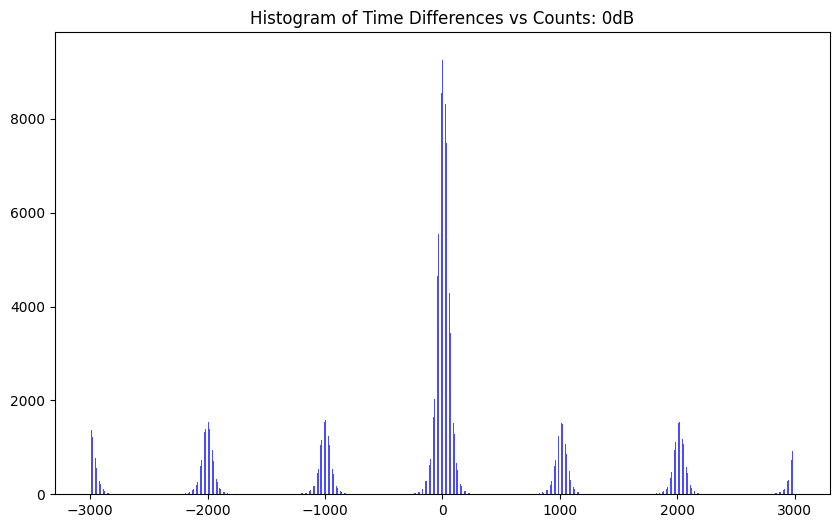

0dB: p = 33.2322, coincidence counts = 947,730


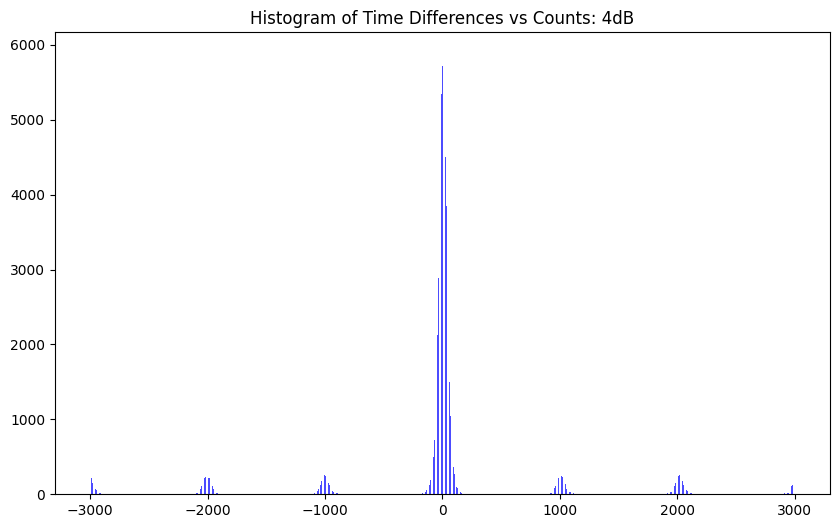

4dB: p = 8.7883, coincidence counts = 305,826


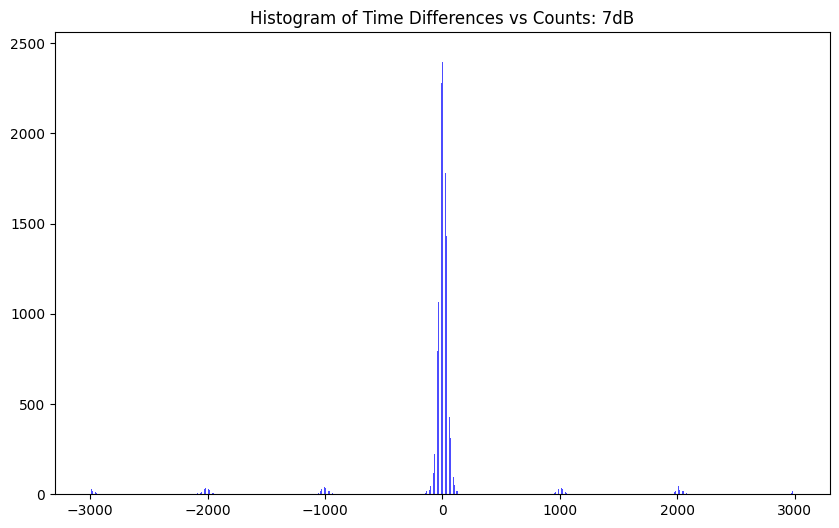

7dB: p = 2.9484, coincidence counts = 101,772


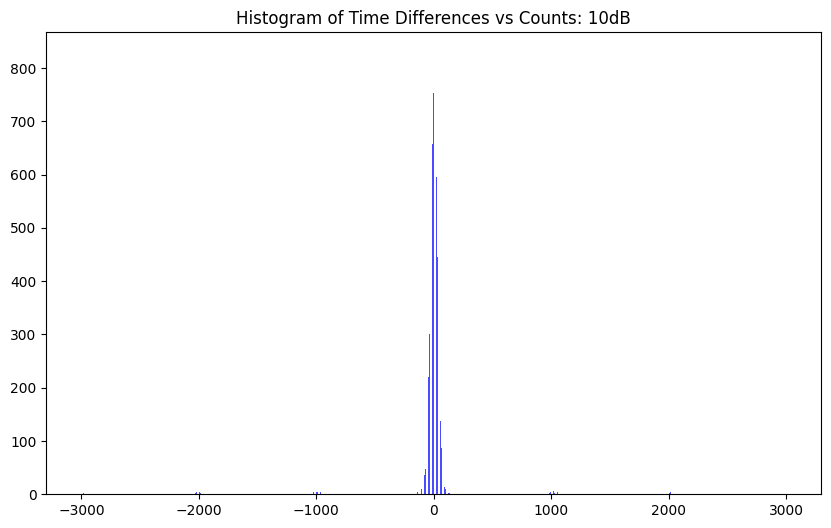

10dB: p = 1.0425, coincidence counts = 29,767


In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

COUNTS = "Counts per bin"
DT = "Time differences (ps)"

root = Path("./chip_data/chip_data/Fourwave mixing histograms")

def make_title(file_path: Path) -> str:
    return file_path.stem.split(" ")[0] + "dB"

def load_df(file_path: Path) -> pd.DataFrame:
    return pd.read_csv(
        file_path,
        delimiter="\t",
    )

def make_plot(df: pd.DataFrame, file_title: str):
    plt.figure(figsize=(10, 6))
    plt.bar(df[DT], df[COUNTS], width=1, color='blue', alpha=0.7)
    plt.title(f"Histogram of Time Differences vs Counts: {file_title}")
    plt.show()
    
    
    
"""
"""

margin = 150
rate = 1000


for file_path in [
                  root / "0 dB attenuation.txt",
                  root / "4 dB attenuation.txt",
                  root / "7 dB attenuation.txt",
                  root / "10 dB attenuation.txt"
                  ]:
    df = load_df(file_path)
    title = make_title(file_path)
    make_plot(df, title)
    big_peak = df[(df[DT]>=-margin) & (df[DT]<=margin)][COUNTS].sum()
    small_peaks = 0
    for i in [-1,1]:
        small_peaks += df[((df[DT]>=rate*i-margin) & (df[DT]<=rate*i+margin))][COUNTS].sum()
    coincidence_count = df[COUNTS].sum()
    p = 100*small_peaks / big_peak
    print(f"{title}: p = {p:.2f}%, coincidence counts = {coincidence_count:,}")



+------+---------------------+---------------------+---------------------+---------------------+----------------------+---------------------+---------------------+----------------------+---------------------+
| meas |         ZZ          |         ZX          |         ZY          |         XZ          |          XX          |         XY          |         YZ          |          YY          |         YX          |
+------+---------------------+---------------------+---------------------+---------------------+----------------------+---------------------+---------------------+----------------------+---------------------+
|  00  | 0.4821150855365474  | 0.2647058823529412  | 0.2600574712643678  | 0.18792866941015088 |  0.3913690476190476  | 0.24480712166172106 | 0.29985443959243085 | 0.023633677991137372 | 0.3009118541033435  |
|  01  | 0.01866251944012442 | 0.23669467787114845 | 0.20977011494252873 | 0.27023319615912206 |       0.03125        | 0.22997032640949555 | 0.23435225618631733 | 

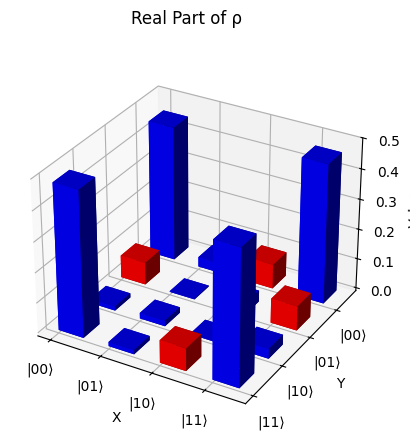

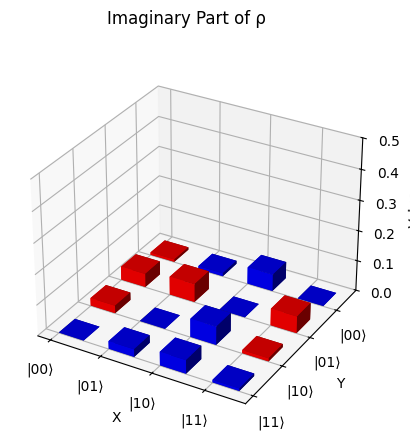

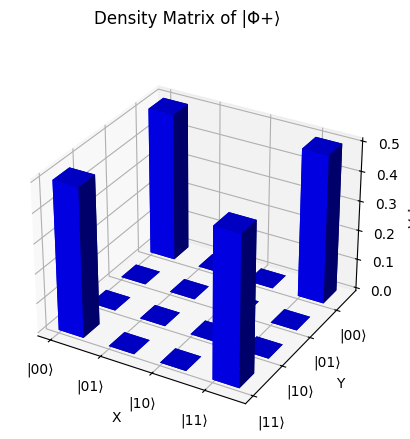

Fidelity: 0.9203


In [ ]:

from collections import defaultdict
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
import tabulate

def prep_df(filepath: str) -> pd.DataFrame:
    df = pd.read_excel(filepath)
    new_df = {"meas":[],"ZZ":[],"ZX":[],"ZY":[],"XZ":[],"XX":[],"XY":[],"YZ":[],"YY":[], "YX":[]}
    helper = defaultdict(dict)
    for col in df.columns:
        meas_base, meas = col[:2], col[2:]
        meas_key = f"{int(meas)-1:02b}"
        helper[meas_key][meas_base] = df.loc[0, col]
    for key, val in helper.items():
        new_df["meas"].append(key)
        for pauli, val2 in val.items():
            new_df[pauli].append(val2)
    df = pd.DataFrame(new_df).set_index("meas")
    return df / df.sum()

file_path="./chip_data/chip_data/Full Tomography Measurements/DensityMatrices_Fid_92.xlsx"

df = prep_df(file_path)
print(tabulate.tabulate(df, headers='keys', tablefmt='pretty',floatfmt=".1f"))

def get(base: str, pauli: str):
    return df.iloc[[int(base, 2)]][pauli].values[0]


def comb(pauli: str, coef: List[int]):
    return sum(coef[i]*get(f"{i:02b}", pauli) for i in range(4))

IZ = comb("ZZ", [1, -1, 1, -1])
ZI = comb("ZZ", [1, 1, -1, -1])
ZZ = comb("ZZ", [1, -1, -1, 1])
IX = comb("ZX", [1, -1, 1, -1])
XI = comb("XZ", [1, 1, -1, -1])
XX = comb("XX", [1, -1, -1, 1])
IY = comb("ZY", [1, -1, 1, -1])
YI = comb("YZ", [1, 1, -1, -1])
YY = comb("YY", [1, -1, -1, 1])
ZX = comb("ZX", [1, -1, -1, 1])
ZY = comb("ZY", [1, -1, -1, 1])
XZ = comb("XZ", [1, -1, -1, 1])
XY = comb("XY", [1, -1, -1, 1])
YX = comb("YX", [1, -1, -1, 1])
YZ = comb("YZ", [1, -1, -1, 1])
II = comb("ZZ", [1, 1, 1, 1])


rho = 0.25 * np.array([
    [II + IZ + ZI + ZZ, IX - 1j*IY + ZX-1j*ZY, XI+XZ-1j*YI-1j*YZ, XX-1j*XY-1j*YX-YY],
    [IX + 1j*IY + ZX+1j*ZY, II - IZ + ZI - ZZ, XX+1j*XY-1j*YX+YY, XI-XZ+-1j*YI+1j*YZ],
    [XI + XZ + 1j*YI + 1j*YZ, XX - 1j*XY + 1j*YX+YY, II + IZ - ZI - ZZ, IX - 1j*IY - ZX + 1j*ZY],
    [XX + 1j*XY + 1j*YX-YY,XI-XZ+1j*YI-1j*YZ,IX+1j*IY-ZX-1j*ZY,II-IZ-ZI+ZZ]
])
sigma = 0.5*np.array([
    [1,0,0,1],
    [0,0,0,0],
    [0,0,0,0],
    [1,0,0,1]
    ])

ketfmt = lambda s: f"|{s:02b}⟩"


def make_fig(data, title):
    xpos, ypos = np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1]), indexing="ij")

    # Flatten everything for plotting
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = np.zeros_like(xpos)

    # Heights of the bars
    dz = data.ravel()

    # Width and depth of each bar
    dx = dy = 0.5

    # Create 3D plot
    fig = plt.figure()
    fig.suptitle(title)
    ax = fig.add_subplot(111, projection='3d')

    ax.bar3d(xpos, ypos, zpos, dx, dy, np.abs(dz), shade=True, color=['r' if z<0 else 'b' for z in dz])


    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Value')
    ax.set_yticks([0, 1, 2, 3], [ketfmt(3-i) for i in range(4)])
    ax.set_xticks([0, 1, 2, 3], [ketfmt(i) for i in range(4)])
    ax.set_zticks([0.1 * i for i in range(6)])

RHO = "ρ"
make_fig(data=np.real(rho), title=f"Real Part of {RHO}")
make_fig(data=np.imag(rho), title=f"Imaginary Part of {RHO}")
make_fig(data=sigma, title=f"Density Matrix of |Φ+⟩")


plt.show()

def calculate_fidelity(rho, sigma):
    X = sqrtm(rho) @ sigma @ sqrtm(rho)
    # numerical cleanup to keep it Hermitian
    X = (X + X.conj().T) / 2
    return (np.real(np.trace(sqrtm(X))))**2

fidelity = calculate_fidelity(rho, sigma)
print(f"Fidelity: {fidelity.real:.4f}")